In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For simplicity, we model an LFP signal recorded using only two electrodes, but this approach can be extended to multi-electode arrays (Uta array). We model the contribution from a local population around the electrode, whose contribution decays with electrode distance from cell and remote population, whose contribution does not depend on space. 

The rationale for the assumption is that the probability of connections between neurons decays very fast in the close neighbourhood of the neuron, but for distances above 1 mm it stays at small but constant level. The size of the remote population is large (it covers much larger area that the local population with a radius of < 1 mm), so that it's contribution can be significant, even if single neurons contribute little. 

Alternatively, the contribution from far population can in-direct, i.e., mediated by common inputs or modulations of excitability rather than direct connections.

In [ ]:
npts = 1000000
N = 1000
rate = 0.1
n_electrodes = 2
kernel_tau = 5.
kernel_amplitudes = [1., 0.1]

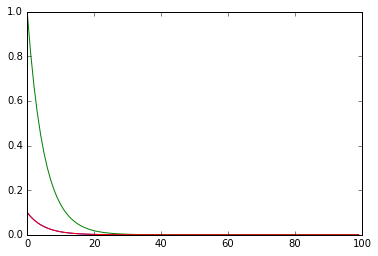

In [63]:
spikes = 1. * (np.random.rand(npts, n_electrodes) > (1-rate))
kernel = np.exp(-np.arange(100)/kernel_tau)[:,None]
kernel = kernel * np.array(kernel_amplitudes[-1:0:-1] + kernel_amplitudes)[None, :]
plt.plot(kernel)

In [ ]:
from scipy import signal
lfp = signal.fftconvolve(spikes, kernel, 'same').T
population = np.random.poisson(N * rate, (npts, n_electrodes))
lfp += population.T

In [75]:
mixture_matrix = np.array([[1., 0.5], [0.5, 1]])
lfp = np.dot(mixture_matrix, lfp)
np.corrcoef(lfp)

array([[ 1.        ,  0.97568848],
       [ 0.97568848,  1.        ]])

In [76]:
from scipy import stats
cov_mat = np.cov(lfp)

In [77]:
def whitening_matrix(cov, cutoff=0.01):
    evals, evecs = np.linalg.eig(cov)

    inv_evals = 1./np.sqrt(evals)
    inv_evals[evals<cutoff*evals.max()] = 0

    w_mat = np.dot(np.dot(evecs, np.diag(inv_evals)), evecs.T)
    
    return w_mat


In [78]:
W = whitening_matrix(cov_mat)
W_opt = np.linalg.inv(mixture_matrix)

In [79]:
spike_triggered = signal.fftconvolve(lfp[:, :], spikes[::-1,0, None].T, 'same')

In [80]:

def plot_sta(spike_triggered):
    def _normalise(x):
        return (x-x.min(0))/x.max()
    N = spike_triggered.shape[1]
    sta = spike_triggered[:, N/2-49:N/2-20].T
    plt.plot(_normalise(sta), lw=2)

    plt.twinx()
    K = kernel[:30, 1:]
    plt.plot(_normalise(K))
    plt.xlim(-10, 50)


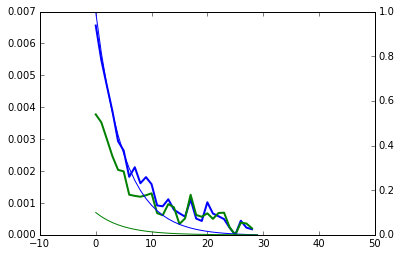

In [70]:
plot_sta(spike_triggered)

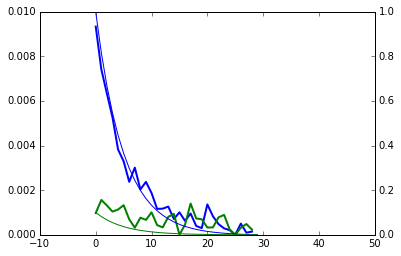

In [71]:

whitened_stlfp = np.dot(W, spike_triggered)

plot_sta(whitened_stlfp)

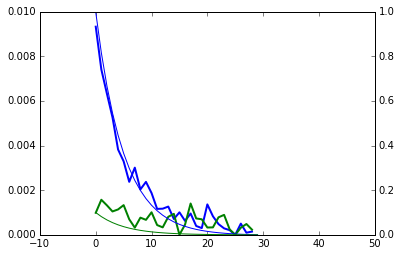

In [72]:

whitened_stlfp = np.dot(W_opt, spike_triggered)

plot_sta(whitened_stlfp)

## Co-modulated Poisson population

In [14]:
npts = 1000000
N = 100
mixture_matrix = np.array([[0.51, 0.49], [0.49, 0.51]])
#mixture_matrix = np.ones((2, 2))
rate = np.dot(mixture_matrix,  np.random.rand(2, npts)).T
spikes = 1. * (rate > 0.6)
population = np.random.poisson(N * rate)
print np.corrcoef(spikes.T)
print np.corrcoef(population.T)
print np.corrcoef(spikes[:, 0], population[:, 0])

[[ 1.          0.97081667]
 [ 0.97081667  1.        ]]
[[ 1.          0.89196482]
 [ 0.89196482  1.        ]]
[[ 1.          0.74060702]
 [ 0.74060702  1.        ]]


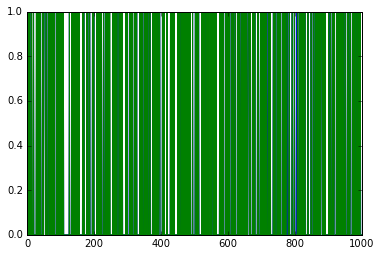

In [15]:
plt.plot(spikes[:1000, :])

In [16]:
spikes.sum(0)

array([ 319465.,  319434.])

In [17]:
kernel = np.exp(-np.arange(100)/10.)[:,None] * np.array([0.1, 1., 0.1])[None, :]

In [18]:
print kernel.shape

(100, 3)


LFP is modelled as a sum of pre-synaptic and post-synaptic contributions:

In [19]:

lfp = signal.fftconvolve(spikes, kernel, 'same').T + population.T
#lfp += N * (rate.T - rate.mean())

In [20]:
cov_mat = np.cov(lfp)
print cov_mat
W = whitening_matrix(cov_mat, 0.01)

[[ 467.71986635  417.34785077]
 [ 417.34785077  467.76950824]]


In [21]:
W

array([[ 0.08724136, -0.05362529],
       [-0.05362529,  0.08723498]])

In [22]:

spikes.sum(0)

array([ 319465.,  319434.])

In [23]:
spike_triggered = signal.fftconvolve(lfp[:, :], spikes[::-1,0, None].T, 'same')
#spike_triggered /= signal.fftconvolve(np.ones_like(lfp), spikes[::-1,0, None].T, 'same')
whitened_stlfp = np.dot(W, spike_triggered)
#whitened_stlfp = np.dot(np.linalg.inv(mixture_matrix), spike_triggered)


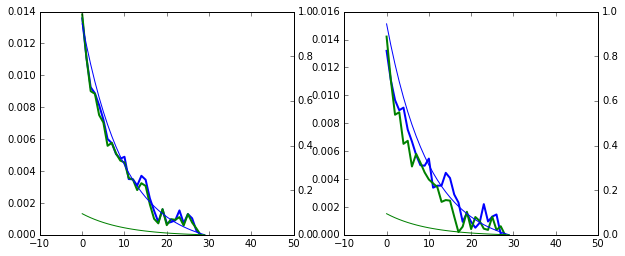

In [24]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_sta(spike_triggered)
plt.subplot(122)
plot_sta(whitened_stlfp)

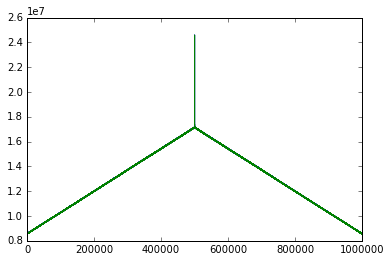

In [25]:

plt.plot(spike_triggered.T)

In [26]:
np.corrcoef(np.dot(W, lfp))

array([[  1.00000000e+00,  -2.14229027e-15],
       [ -2.14229027e-15,   1.00000000e+00]])

In [27]:
signal.fftconvolve(np.ones_like(lfp), spikes[::-1,0, None].T, 'same')

array([[ 159812.,  159813.,  159813., ...,  159653.,  159653.,  159653.],
       [ 159812.,  159813.,  159813., ...,  159653.,  159653.,  159653.]])

In [28]:
spikes.shape[0]

1000000